# 3.2 线性回归的从零开始实现
- **目录**
  - 3.2.1 生成数据集
  - 3.2.2 读取数据集
  - 3.2.3 初始化模型参数
  - 3.2.4 定义模型
  - 3.2.5 定义损失函数
  - 3.2.6 定义优化算法
  - 3.2.7 训练

- 从零开始实现线性回归，包括**数据流水线、模型、损失函数和小批量随机梯度下降优化器**。
- 从零开始实现可以深入理解算法和模型。
- 了解更细致的工作原理更便于**自定义模型、自定义层或自定义损失函数**。
- 在这一节中将只使用**张量**和**自动求导**实现线性回归。
- 后一节将充分利用深度学习框架的优势，介绍更简洁的实现方式。

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 3.2.1 生成数据集
- 首先根据带有噪声的线性模型构造一个**低维模拟数据集**。
- 然后使用这个有限样本的数据集估计模型的参数。
- 数据集包含1000个样本的数据集，每个样本包含从**标准正态分布**中采样的2个特征。
- 模拟数据集的自变量是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。
- 使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
- $\epsilon$视为模型预测和标签时的**潜在观测误差**（其实就是残差值）。
  - $\epsilon$服从均值为0的正态分布。
  - 此处将标准差设为0.01。

In [4]:
# 和前一节的例子只有一个特征相比，本数据集更显复杂，有两个特征
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) ##特征
    y = torch.matmul(X, w) + b ##目标
    y += torch.normal(0, 0.01, y.shape) ##加上噪声
    return X, y.reshape((-1, 1)) ##返回样本数据和标签

In [5]:
# 模拟数据的真实权重和偏置
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# 返回数据称为特征和标签，其实就是回归分析里的自变量和因变量
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape,labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

- 注意，`features`中的每一行都包含一个**二维数据样本**，
`labels`中的每一行都包含**一维标签值**（一个标量）。


In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.2559,  0.4500]) 
label: tensor([2.1604])


- 通过生成**第二个特征**`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


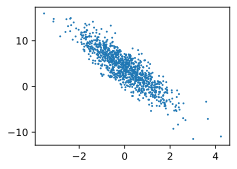

In [7]:
d2l.set_figsize() #默认figsize=(3.5, 2.5)
# 注意detach函数的用法，该函数将数据从张量中分离出来，避免自动微分或自动梯度计算
# 此处只是显示数据，无需梯度计算
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 3.2.2 读取数据集

- 训练模型时要对数据集进行遍历，每次抽取**一小批量样本**，用之更新模型。
- 设计函数，打乱数据集中的样本并以小批量方式获取数据。
- 示例：定义一个`data_iter`函数：
  - 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量。
  - 每个小批量包含一组特征和标签。


In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 生成数据的索引
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    # shuffle函数可以打乱数据的顺序，
    # 此处是打乱索引顺序
    random.shuffle(indices)
    ##按照batch_size取多少个indices
    for i in range(0, num_examples, batch_size):
        # 通过索引进行切片
        '''
        注意indices[i: min(i + batch_size, num_examples)]中min函数作用。
        在对数据进行批量切分时，最后一个批量一般要小于batch_size
        （或者刚好等于batch_size，但是这种很罕见，除非数据量刚好是batch_size的整数倍），
        因此通过i + batch_size切分到最后一个小批量时，i + batch_size下标有可能超过
        indices的size，从而产生下标索引越界的异常情况。因此此处通过min函数就可以避免这种异常。
        即取最后一个小批量的索引时，只取到indices的最后一个元素（包含最后一个）为止。
        '''
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        ## 生成器，返回小批量的特征和标签
        ## 训练模型时，小批量的取出一般是迭代式的，yield可以实现此功能
        yield features[batch_indices], labels[batch_indices]

- 小批量与GPU相结合的优势：
  - 在GPU上，每个样本都可以并行地进行模型计算，且每个样本损失函数的**梯度也可以被并行计算**。
  - GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。
  - 主流深度学习框架实现的内置迭代器效率要高得多，能高效处理存储在文件中的数据和数据流提供的数据。

- **示例：小批量运算**
  - 读取第一个小批量数据样本并打印。
  - 每个批量的特征维度显示批量大小(本例为10)和输入特征数（本例为2）。
  - 批量的标签形状与`batch_size`相等（本例为10）。

In [9]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3731,  0.2761],
        [ 0.1922,  0.0572],
        [-0.4616, -0.5650],
        [-1.0563,  0.0153],
        [ 0.5629,  1.0484],
        [-0.3476, -1.3563],
        [ 0.9261,  1.1226],
        [ 0.8463,  0.4736],
        [-0.5467,  0.6778],
        [-0.2913,  1.3571]]) 
 tensor([[ 4.0045],
        [ 4.4008],
        [ 5.2020],
        [ 2.0452],
        [ 1.7570],
        [ 8.1135],
        [ 2.2406],
        [ 4.2849],
        [ 0.7803],
        [-0.9659]])


## 3.2.3 初始化模型参数

- 在开始优化模型参数之前，需要对参数赋予一些值，称之为**初始化**.

- 下例中，通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。


In [10]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

- 在初始化参数之后，接下来的任务是更新这些参数，直到这些参数足够拟合训练数据。
- 每次更新都需要计算损失函数关于模型参数的梯度，然后就可以向减小损失的方向更新每个参数。
- 深度学习框架通过自动微分来计算梯度。

## 3.2.4 定义模型

- 接下来**定义模型，将模型的输入和参数同模型的输出关联起来。**
- 要计算线性模型的输出，只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的**矩阵-向量乘法**后加上偏置$b$。
  - 注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
- 因此下述模型的计算使用到广播机制：**用一个向量加一个标量时，标量会被加到向量的每个分量上**。

In [11]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

----------

- **说明：matmul函数的用法**
  - 以上述线性回归模型为例，为了不干扰原代码的计算过程，示例使用不同的标识符。
  - h是形状为(10, 2)的矩阵，即模型中的X。
  - j是形状为(10, )的向量，即模型中的w。
  - i是一个标量，即模型中的b。

In [12]:
# 形状为(10, 2)的矩阵
h=torch.normal(0, 1, (10, 2))
# 维度为2的向量
j=torch.normal(1, 2, (2, ))
# 标量
i=torch.normal(4, 5, (1,))
'''
下述矩阵-向量乘法和加法使用到广播机制，张量的形状变化过程如下：
（1）下述计算数据的形状为：h@j + i = (10, 2)@(2) + (1)。
（2）torch.matmul(h, j) = (10, 2)@(2, )=(10, )。
     注意此步计算，是将(2,)从行向量转换成列向量，其实质的计算形式应该是(10, 2)@(2, 1) = (10, 1)。
     但是Pytorch与Numpy多维数组的计算方式类似，计算结果简化成一个一维数组(10, )，也就是一个行向量；
     而不是(10, 1)这样的二维数组，即列向量。
（3）然后对i进行广播：(1,)变成(10,)，即(10,) + (10,) = (10,)的最终结果。
（4）形状(10,)在Pytorch表示为torch.Size([10])。
'''
r = torch.matmul(h, j) + i
r, r.shape, j.shape, h.shape, i.shape, (torch.matmul(h, j)).shape

(tensor([ 6.3773, 12.3017,  7.9088,  5.9442,  7.6114,  7.4318, 14.5444,  3.4180,
          6.8819,  9.0415]),
 torch.Size([10]),
 torch.Size([2]),
 torch.Size([10, 2]),
 torch.Size([1]),
 torch.Size([10]))

- Numpy的多维数组乘法：
  - Pytorch的张量计算与Numpy的多维数组计算方式很相似。
  - 不同之处在于形状的表示方面。

In [13]:
# 通过一个Numpy和Scipy的例子更直观
import numpy as np
import scipy.stats as stats
# h是多维数组
h = stats.norm.rvs(0, 1, (10,2))
# j是向量
j = stats.norm.rvs(1, 2, (2,))
# i是标量
i = stats.norm.rvs(4, 5)
# 注意i是一个标量，因此其形状为空
h.shape, j.shape, i.shape

((10, 2), (2,), ())

In [14]:
# (h@j) + i的计算对i进行了广播，形状变成(10,)
((h@j) + i).shape

(10,)

In [15]:
# 计算结果
(h@j) + i

array([11.89332523, 13.09330961, 12.05091112, 11.92616127, 11.8865604 ,
       12.66194546, 12.18380016, 11.53149651, 12.13751589, 12.84215544])

- Numpy的矩阵乘法：
  - 与多维数组乘法的表现又有所不同。
  - 严格按照矩阵而不是多维数组的规则来进行计算。
  - 也从侧面证实了Pytorch的张量和Numpy多维数组的计算方式很相似。

In [16]:
# 通过一个Numpy的矩阵计算
import numpy as np
import scipy.stats as stats
# h是矩阵
h = np.matrix(stats.norm.rvs(0, 1, (10,2)))
# j是向量
j = stats.norm.rvs(1, 2, (2,))
# i是标量
i = stats.norm.rvs(4, 5)
# 注意标量i的形状为空
h.shape, j.shape, i.shape

((10, 2), (2,), ())

In [16]:
# 此处也对i进行了广播，将其形状变成(1, 10)
(h@j) + i

matrix([[13.6234948 ,  3.9813139 , 14.25509297,  1.98778694,  9.54967167,
          7.65427069,  1.43101001, 14.05737966,  0.0801815 ,  5.72694232]])

In [17]:
# 矩阵计算的形状变换过程更严格
(h@j).shape, ((h@j)+i).shape

((1, 10), (1, 10))

In [17]:
# torch.mm函数的用法
m1 = torch.arange(0,24).reshape(3,8)
m2 = torch.arange(0,16).reshape(8,2)
v1 = torch.arange(0,8)
torch.mm(m1,m2)

tensor([[ 280,  308],
        [ 728,  820],
        [1176, 1332]])

In [18]:
# 但是无法使用mm函数进行矩阵-向量乘法
torch.mm(m1,v1)

RuntimeError: mat2 must be a matrix

In [19]:
# matmul则可以进行矩阵-向量乘法，对第二个参数广播之后进行,效果和mv一样
# 从这个意义上讲，matmul函数与@操作符功能是一致的
torch.matmul(m1,v1), torch.mv(m1,v1), m1@v1

(tensor([140, 364, 588]), tensor([140, 364, 588]), tensor([140, 364, 588]))

----------

## 3.2.5 **定义损失函数**

- 因需要计算损失函数（或目标函数）的梯度，所以应该先定义损失函数：
  - 使用平方损失函数（平方误差，见3.1节）作为损失函数（或目标函数）。
  - 在实现代码时，需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [20]:
def squared_loss(y_hat, y): 
    """均方损失"""
    # 注意reshape的用法
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 **定义优化算法**

- 线性回归有解析解，此处介绍**小批量随机梯度下降**，用来获得**最优解**作为**数值解**。
  - 使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
  - 然后朝着减少损失的方向**更新参数**。
- 下面的函数实现小批量随机梯度下降更新：
  - 该函数接受**模型参数集合**、**学习速率**和**批量大小**作为输入。
  - 每一步更新的大小由学习速率`lr`决定。
  - 因为计算的损失是一个批量样本的总和，所以此处用批量大小（`batch_size`）来规范化步长，即除以`batch_size`。


In [21]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 除以batch_size用于规范化步长
            '''
            除以batch_size是与模型训练阶段调用l.sum().backward()对应，具体机制后面详细解释。
            '''
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练 

- 实现主要的**训练过程**：
  - 在每次迭代中，读取一小批量训练样本，并通过的模型来获得一组预测。
  - 计算完损失后，开始反向传播，存储每个参数的梯度。
  - 最后调用优化算法`sgd`来更新模型参数。

- 训练过程执行以下循环：
  * 初始化参数
  * 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

- 在每个**迭代周期（epoch）** 中，使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
- 这迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
  -  **超参数调优**是深度学习中很重要的内容，后面将多次介绍。

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [24]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # X和y的小批量损失
        l = loss(net(X, w, b), y) 
        
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        '''
        注意此处是求小批量的损失之和，然后再求梯度，因此该梯度是小批量中10条样本数据
        的损失之和关于w,b的梯度。
        于是在sgd函数对参数进行优化更新时，需要对梯度除以小批量的大小即batch_size，
        从而对应了样本数据中每条数据的梯度，这样便于更精细地更新参数w,b。
        在实践中，梯度过大或过小都有可能造成问题，前者有可能导致梯度爆炸，无法收敛；
        后者有可能导致梯度太小，收敛速度太慢。
        当然要防止上述两种情况，主要还是要靠优化方法的选择以及学习率的调优。
        '''
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000050
epoch 3, loss 0.000049


In [25]:
w,b,true_w,true_b

(tensor([[ 1.9998],
         [-3.4001]], requires_grad=True),
 tensor([4.1999], requires_grad=True),
 tensor([ 2.0000, -3.4000]),
 4.2)

- 可以通过**比较真实参数和通过训练学到的参数来评估训练的成功程度**
  - 小批量随机梯度下降算法的功能十分强大

In [26]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0002, 0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([5.7220e-05], grad_fn=<RsubBackward1>)


## 小结

* 学习深度网络是如何实现和优化的。
* 只使用张量和自动微分，不需要定义层或复杂的优化器。